<a href="https://colab.research.google.com/github/kornellewy/12-Dimensionality-Reduction-Techniques/blob/master/12_Dimensionality_Reduction_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
# get data 
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

# 3.1 Missing Value Ratio

In [0]:
train = pd.read_csv("Train_UWu5bXk.csv")

In [16]:
# nuls ?
train.isnull().sum()/len(train)*100 # bo %

Item_Identifier               0.000000
Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [17]:
nuls = train.isnull().sum()/len(train)*100
vars = train.columns
var = []
for i in range(0,12):
    if (nuls[i]<=20):
        var.append(vars[i])
var

['Item_Identifier',
 'Item_Weight',
 'Item_Fat_Content',
 'Item_Visibility',
 'Item_Type',
 'Item_MRP',
 'Outlet_Identifier',
 'Outlet_Establishment_Year',
 'Outlet_Location_Type',
 'Outlet_Type',
 'Item_Outlet_Sales']

So the variables to be used are stored in “variable”, which contains only those features where the missing values are less than 20%.

# 3.2 Low Variance Filter

Let’s first impute the missing values in the Item_Weight column using the median value of the known Item_Weight observations

In [0]:
train['Item_Weight'].fillna(train['Item_Weight'].median(), inplace=True)
train['Outlet_Size'].fillna(train['Outlet_Size'].mode()[0], inplace=True)

In [19]:
train.isnull().sum()/len(train)*100

Item_Identifier              0.0
Item_Weight                  0.0
Item_Fat_Content             0.0
Item_Visibility              0.0
Item_Type                    0.0
Item_MRP                     0.0
Outlet_Identifier            0.0
Outlet_Establishment_Year    0.0
Outlet_Size                  0.0
Outlet_Location_Type         0.0
Outlet_Type                  0.0
Item_Outlet_Sales            0.0
dtype: float64

calculate all varible variance :

In [20]:
train.var()

Item_Weight                  1.786956e+01
Item_Visibility              2.662335e-03
Item_MRP                     3.878184e+03
Outlet_Establishment_Year    7.008637e+01
Item_Outlet_Sales            2.912141e+06
dtype: float64

As the above output shows, the variance of Item_Visibility is very less as compared to the other variables.

In [25]:
# get numeric columns
num = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = train.select_dtypes(include=num)
var = numeric.var()
numeric = numeric.columns
vars = []
for i in range(0, len(var)):
    if (var[i] >= 10):
        vars.append(numeric[i])
vars

['Item_Weight', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']

# 3.3 High Correlation filter

High correlation between two variables means they have similar trends and are likely to carry similar information. This can bring down the performance of some models drastically (linear and logistic regression models, for instance). We can calculate the correlation between independent numerical variables that are numerical in nature. If the correlation coefficient crosses a certain threshold value, we can drop one of the variables (dropping a variable is highly subjective and should always be done keeping the domain in mind).

In [26]:
train.corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.014168,0.024951,0.007739,0.009693
Item_Visibility,-0.014168,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024951,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,0.007739,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.009693,-0.128625,0.567574,-0.049135,1.000000


**As a general guideline, we should keep those variables which show a decent or high correlation with the target variable.**

Wonderful, we don’t have any variables with a high correlation in our dataset. Generally, if the correlation between a pair of variables is greater than 0.5-0.6, we should seriously consider dropping one of those variables.

# 3.4 Random Forest

Random Forest is one of the most widely used algorithms for feature selection. It comes packaged with in-built feature importance so you don’t need to program that separately. This helps us select a smaller subset of features.

We need to convert the data into numeric form by applying one hot encoding, as Random Forest (Scikit-Learn Implementation) takes only numeric inputs. Let’s also drop the ID variables (Item_Identifier and Outlet_Identifier) as these are just unique numbers and hold no significant importance for us currently.

In [28]:
from sklearn.ensemble import RandomForestRegressor
df=train.drop('Item_Outlet_Sales', 1)
df = df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
model = RandomForestRegressor(random_state=1, max_depth=10)
# one hot encoding
df = pd.get_dummies(df)
model.fit(df, train.Item_Outlet_Sales)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

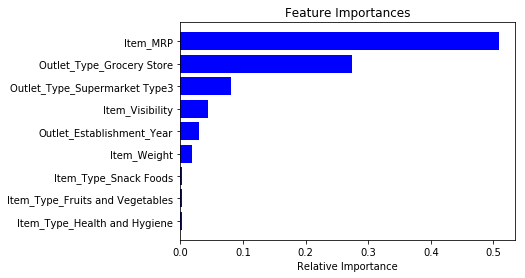

In [29]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Based on the above graph, we can hand pick the top-most features to reduce the dimensionality in our dataset. Alernatively, we can use the SelectFromModel of sklearn to do so. It selects the features based on the importance of their weights.

In [0]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
fit = feature.fit_transform(df, train.Item_Outlet_Sales)

# 3.5 Backward Feature Elimination


    -We first take all the n variables present in our dataset and train the model using them
    -We then calculate the performance of the model
    -Now, we compute the performance of the model after eliminating each variable (n times), i.e., we drop one variable every time and train the model on the remaining n-1 variables
    -We identify the variable whose removal has produced the smallest (or no) change in the performance of the model, and then drop that variable
    -Repeat this process until no variable can be dropped


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn import datasets

In [41]:
lreg = LinearRegression()
rfe = RFE(lreg, 10)
rfe = rfe.fit_transform(df, train.Item_Outlet_Sales)
rfe

array([[0.0160473 , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.01927822, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01676007, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.03518627, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.14522065, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04487828, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

# 3.6 Forward Feature Selection


    -We start with a single feature. Essentially, we train the model n number of times using each feature separately
    -The variable giving the best performance is selected as the starting variable
    -Then we repeat this process and add one variable at a time. The variable that produces the highest increase in performance is retained
    -We repeat this process until no significant improvement is seen in the model’s performance


In [42]:
from sklearn.feature_selection import f_regression
ffs = f_regression(df,train.Item_Outlet_Sales )
ffs

(array([8.00638865e-01, 1.43345451e+02, 4.04945623e+03, 2.06215699e+01,
        1.30806126e+00, 1.22585958e+00, 4.36138028e+00, 3.41026049e-01,
        1.95567521e+00, 1.25710921e+01, 4.63353942e-02, 1.84715461e-01,
        4.64996489e-01, 6.68692267e-01, 7.66102777e-01, 5.74173896e+00,
        1.33379794e-01, 5.58240389e+00, 2.10122944e+00, 7.64508603e-02,
        3.85572723e+00, 4.64101498e-01, 4.42472434e+00, 4.92726368e+00,
        1.92759704e+00, 4.98080532e+00, 4.84013114e+01, 8.33163800e+01,
        1.06854461e+02, 2.90220724e+01, 1.83660511e+01, 1.73932135e+03,
        1.02009171e+02, 1.23601667e+01, 9.13656782e+02]),
 array([3.70927701e-001, 9.04128718e-033, 0.00000000e+000, 5.67308211e-006,
        2.52778104e-001, 2.68245018e-001, 3.67921182e-002, 5.59253023e-001,
        1.62012996e-001, 3.93861711e-004, 8.29572434e-001, 6.67362647e-001,
        4.95316603e-001, 4.13530779e-001, 3.81450067e-001, 1.65878107e-002,
        7.14962237e-001, 1.81641436e-002, 1.47217554e-001, 7.8

This returns an array containing the F-values of the variables and the p-values corresponding to each F value. For our purpose, we will select the variables having F-value greater than 1

In [0]:
variable = [ ]
for i in range(0,len(df.columns)-1):
    if ffs[0][i] >=10:
       variable.append(df.columns[i])

**NOTE : Both Backward Feature Elimination and Forward Feature Selection are time consuming and computationally expensive.They are practically only used on datasets that have a small number of input variables.**